In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np

X = np.load('../SignLanguage/X.npy')
Y = np.load('../SignLanguage/Y.npy')


In [2]:
X.shape

(2062, 64, 64)

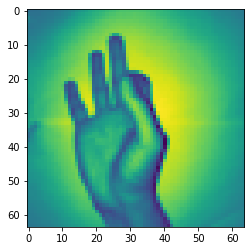

In [3]:
plt.imshow(X[0])

In [4]:
9 - np.argmax(Y[0])

9

To start with let's flatten our data into 2062 4096 dim vectors and split the dataset into training and testing sets.

In [5]:
X_flat = np.array(X).reshape((2062, 64*64))
X_flat.shape
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

In [6]:
X_train.shape

(1443, 4096)

To demonstrate how dimensionality reduction can improve the results of a model we need a model. Here is a very basic, fully connected neural net

In [7]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1)
clf.fit(X_train, y_train)

C:\Users\utilisateur\Anaconda3\envs\computer_vision\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [8]:
y_hat = clf.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, y_hat)))

accuracy: 0.3360258481421648


As you can see, this is a pretty poor model, only achieving ~30% overall accuracy on the test set.

We're now goint to reduce the dimension of our training data and then retrain what we have.

In [9]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [10]:
d

292

Wow - so we've gone from 4096 dimensions to just 292! But how good is this actually?

Let's train PCA on our training set and transform the data, then print out an example

In [11]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (1443, 292)
recovered shape: (1443, 4096)


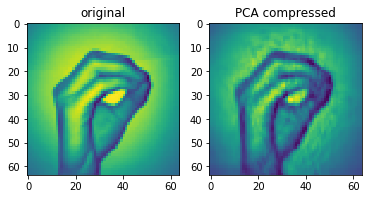

In [13]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

You can see it's far from perfect, but it's still clear what shape the hand is making

Let's retrain our model with the dimensionally reduced training data:

In [14]:
clf_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20))
clf_reduced.fit(X_reduced, y_train)

C:\Users\utilisateur\Anaconda3\envs\computer_vision\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [15]:
X_test_reduced = pca.transform(X_test)

y_hat_reduced = clf_reduced.predict(X_test_reduced)

print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))

accuracy: 0.6752827140549273


And as you can see we've taken this simple model from ~30% accuracy on the test set to ~65%

In [16]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

for i in range (0,1443):
    principalDf.loc[i, 'Label'] = np.argmax(y_train[i])

principalDf

,principal component 1,principal component 2,Label
0,-3.054662,0.438065,1.0
1,1.038543,4.973862,4.0
2,-1.517620,5.229363,1.0
3,0.705151,-0.568546,4.0
4,-3.298279,1.071832,9.0
...,...,...,...
1438,-0.218196,2.581757,7.0
1439,0.565644,-1.829154,5.0
1440,0.106806,-1.666037,5.0
1441,-1.064746,3.844212,6.0


In [17]:
df = principalDf.head(100)

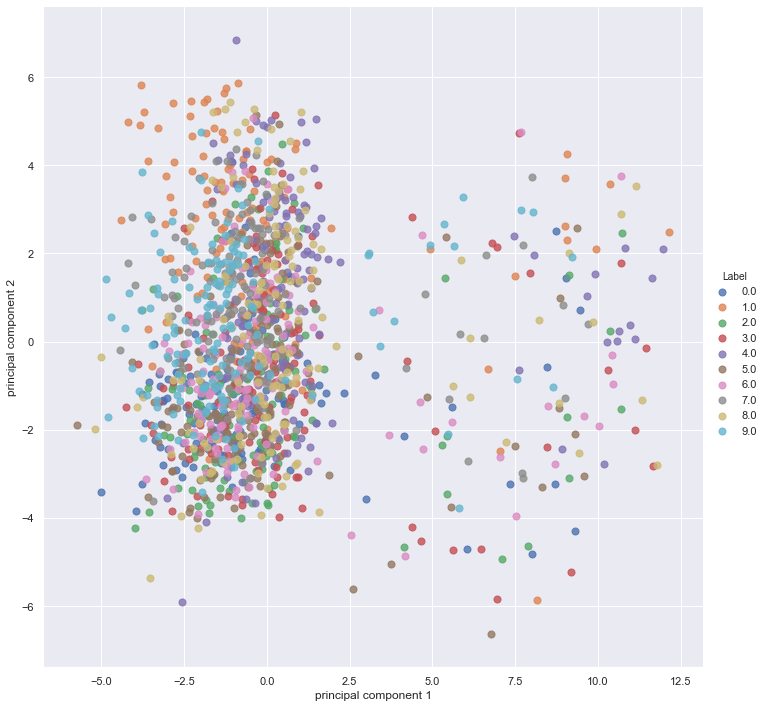

In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,10.27)})
#sns.scatterplot(x="principal component 1", y="principal component 2", hue="Label", data=principalDf)
sns.lmplot(x="principal component 1", y="principal component 2", hue="Label", height=10, data=principalDf, 
    fit_reg=False, 
    legend=True,
    scatter_kws={"s": 50}) # specify the point size